In [1]:
from matplotlib import pyplot as plt

import numpy as np
np.random.seed(42)
import random
random.seed(42)

# Question 1

Fetch dataset

In [5]:
from sklearn.datasets import fetch_20newsgroups

categories = ['comp.sys.ibm.pc.hardware', 'comp.graphics',
              'comp.sys.mac.hardware', 'comp.os.ms-windows.misc',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

Create TF-IDF matrix

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# count
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_counts = vectorizer.fit_transform(dataset.data)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print("Dimension of TF-IDF matrix is ",X_tfidf.shape)

Dimension of TF-IDF matrix is  (7882, 27768)


# Question 2

K-means directly on full-dimension data

In [9]:
from sklearn.cluster import KMeans
from sklearn import metrics

km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
km.fit(X_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=30, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

Overwrite original labels with bin labels

In [16]:
_, idx = np.unique(dataset.target, return_index=True)
for i in range(len(idx)):
    j = np.sort(idx)[i]
    print(dataset.target_names[i],': target index = ', dataset.target[j])

comp.graphics : target index =  2
comp.os.ms-windows.misc : target index =  1
comp.sys.ibm.pc.hardware : target index =  3
comp.sys.mac.hardware : target index =  6
rec.autos : target index =  5
rec.motorcycles : target index =  7
rec.sport.baseball : target index =  4
rec.sport.hockey : target index =  0


In [28]:
labels = np.zeros_like(dataset.target)
for y in [2,1,3,6]:
    labels[np.argwhere(dataset.target == y)] = 0
for y in [5,7,4,0]:
    labels[np.argwhere(dataset.target == y)] = 1
class_names = ['Computer Technology', 'Recreational Activity']

In [29]:
cm = metrics.cluster.contingency_matrix(labels, km.labels_)
print("contingency table \n",cm)

contingency table 
 [[ 797 3127]
 [ 925 3033]]


# Question 3

In [30]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("adjusted_mutual_info_score: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.labels_))

Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand-Index: 0.001
adjusted_mutual_info_score: 0.001


# Question 4

In [39]:
from sklearn.decomposition import TruncatedSVD
import heapq

svd = TruncatedSVD(n_components=1000, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

0.5601128681067258

From i=1000 to 1, choose the first i-th most significant features

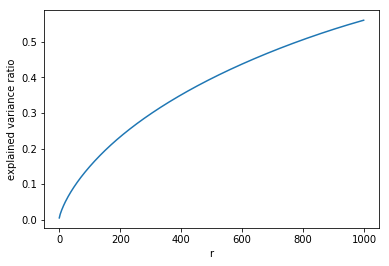

In [59]:
import heapq
evr = np.zeros(1000)
for i in range(1000,0,-1):
    evr[i-1] = np.array(heapq.nlargest(i,svd.explained_variance_ratio_)).sum()
plt.xlabel("r")
plt.ylabel("explained variance ratio")
plt.plot(evr)

# Question 5

In [84]:
r_list = [1,2,3,5,10,20,50,100,300]

homo = np.zeros(9)
comp = np.zeros(9)
vmea = np.zeros(9)
ari = np.zeros(9)
ami = np.zeros(9)

Using truncated SVD

In [71]:
for i,r in enumerate(r_list):
    # compute X_reduced
    svd = TruncatedSVD(n_components=r, random_state=42)
    X_reduced = svd.fit_transform(X_tfidf)
    # do K-means on X_reduced
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    km.fit(X_reduced)
    # evaluate using 5 measure scores
    homo[i] = metrics.homogeneity_score(labels, km.labels_)
    comp[i] = metrics.completeness_score(labels, km.labels_)
    vmea[i] = metrics.v_measure_score(labels, km.labels_)
    ari[i] = metrics.adjusted_rand_score(labels, km.labels_)
    ami[i] = metrics.adjusted_mutual_info_score(labels, km.labels_)       

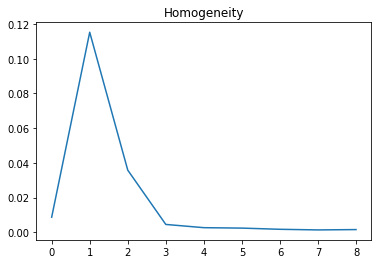

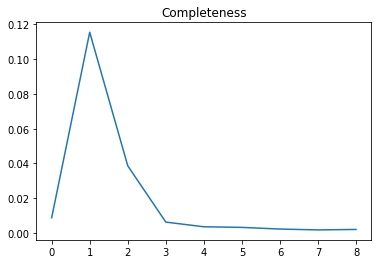

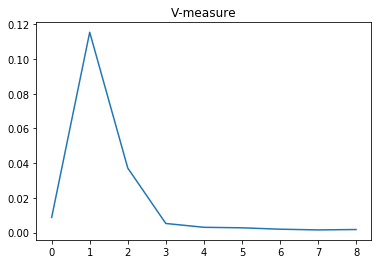

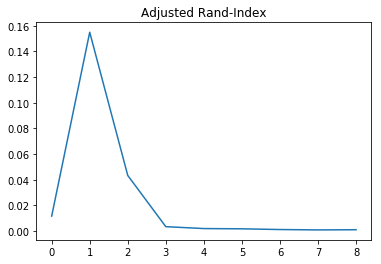

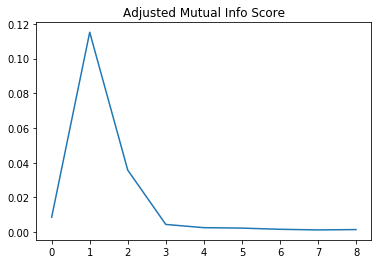

In [80]:
plt.figure();plt.plot(homo);plt.title("Homogeneity")
plt.figure();plt.plot(comp);plt.title("Completeness")
plt.figure();plt.plot(vmea);plt.title("V-measure")
plt.figure();plt.plot(ari);plt.title("Adjusted Rand-Index")
plt.figure();plt.plot(ami);plt.title("Adjusted Mutual Info Score")

plt.show()

Using NMF

In [88]:
from sklearn.decomposition import NMF

for i,r in enumerate(r_list):
    # compute X_reduced
    nmf = NMF(n_components=r, init='random', random_state=42)
    X_reduced = nmf.fit_transform(X_tfidf)
    # do K-means on X_reduced
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    km.fit(X_reduced)
    # evaluate using 5 measure scores
    homo[i] = metrics.homogeneity_score(labels, km.labels_)
    comp[i] = metrics.completeness_score(labels, km.labels_)
    vmea[i] = metrics.v_measure_score(labels, km.labels_)
    ari[i] = metrics.adjusted_rand_score(labels, km.labels_)
    ami[i] = metrics.adjusted_mutual_info_score(labels, km.labels_)    

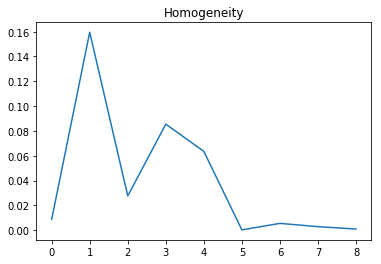

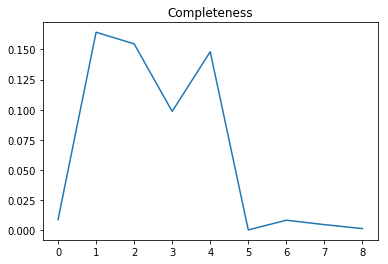

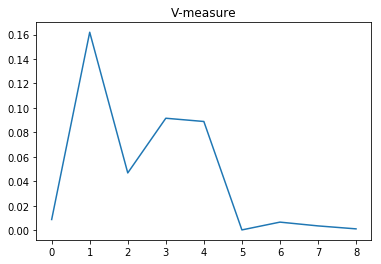

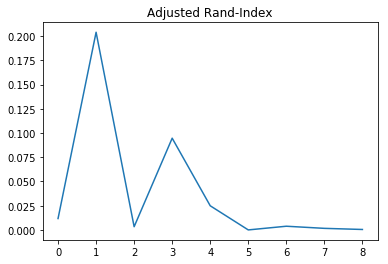

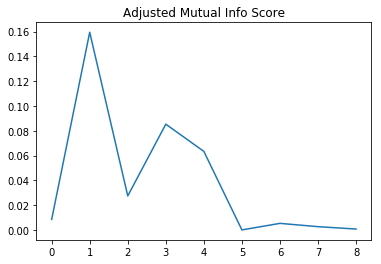

In [90]:
plt.figure();plt.plot(homo);plt.title("Homogeneity")
plt.figure();plt.plot(comp);plt.title("Completeness")
plt.figure();plt.plot(vmea);plt.title("V-measure")
plt.figure();plt.plot(ari);plt.title("Adjusted Rand-Index")
plt.figure();plt.plot(ami);plt.title("Adjusted Mutual Info Score")

plt.show()